# Computation Graph and Back Propagation

- Gradient를 빠르게 구하는 방법으로 오차역전파법을 사용한다.   
- 오차역전파법은 계산 그래프상에서 결과 값으로부터 로컬미분값을 
역순으로 구하여 각 층의 계산 노드의 수치증감분(편미분값)을 계산한다. 
- 도함수의 연쇄법칙 chain rule 이 그 원리이다.
$$
\frac{\partial f}{\partial x} = \sum_i\frac{\partial f}{\partial u_i} \frac{\partial u_i}{\partial x}
$$ 

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import itertools


## 1. Computation Graph 계산 그래프
- 계산 그래프의 노드node는 연산자(연산식)이고 계산 결과를 노드의 value로 가진다.
- 이 연산자 노드를 계산 순서에 맞게 연결하여 계산과정을 표현한 것이 계산 그래프이다.
- 예를 들어 원금 $A$를 연이자율 $r$로 $n$년간 예금한다고 할 때 만기시 원리금 총액 $M$은 다음과 같을 것이다.
$$
M = A(1 + r)^n
$$
    - 이 식을 계산 그래프로 나타내면,

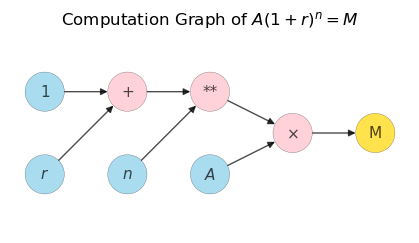

In [121]:
from re import sub


subset_sizes = (2, 2, 2, 1, 1)
subset_color = [
    "skyblue",
    "pink",
    "gold"
]
options = {
    "font_size": 11,
    "node_size": 800,
    "edgecolors": "black",
    "linewidths": 0.2,
    "width": 1,
    "alpha": 0.7,
}
values= [r"$1$",r"$r$",r"$+$", r"$n$", "**", r"$A$", r"$\times$", r"M"]
extents = nx.utils.pairwise(itertools.accumulate((0,) + subset_sizes))
layers = [range(start, end) for start, end in extents ]

G = nx.DiGraph()
for i, layer in enumerate(layers):
    G.add_nodes_from(layer, layer=i)
for i in range(8):
    G.nodes[i]['value'] = values[i]
edges = [(0, 2), (1, 2), (2, 4), (3, 4), (4, 6), (5, 6),(6, 7)]
G.add_edges_from(edges)
color = subset_color[:1] * 2 
color += subset_color[1:2]
color += subset_color[:1]
color += subset_color[1:2]
color += subset_color[:1]
color += subset_color[1:2]
color += subset_color[-1:]
pos = nx.multipartite_layout(G, subset_key="layer")
labels = nx.get_node_attributes(G, 'value')
plt.figure(figsize=(4, 2))
nx.draw(G, pos=pos, labels=labels, node_color=color, with_labels=True, **options)
plt.title('Computation Graph of $A(1+r)^n = M$')
plt.axis("equal")
plt.show()
    

## 2. back-propagation


[(2, 0), (2, 1), (4, 2), (4, 3), (6, 4), (6, 5), (7, 6)]


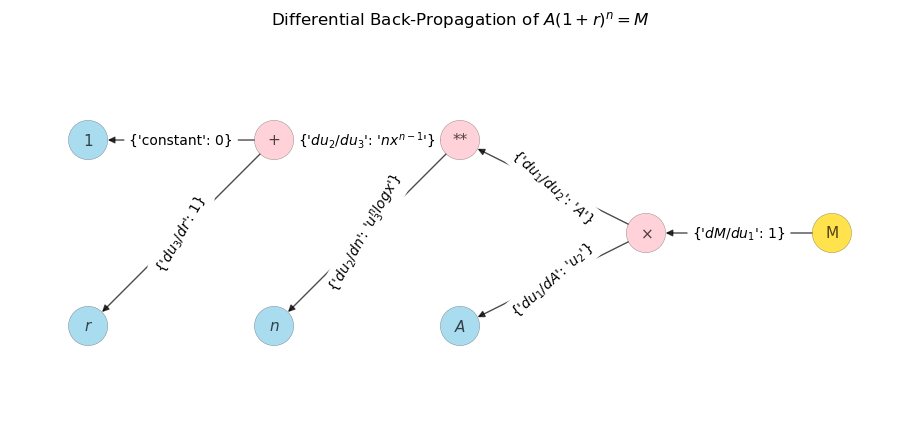

In [149]:
values_ = [r"\partial d"] 

G_reversed = nx.reverse(G)
print(G_reversed.edges)
G_reversed.edges[(7, 6)][r'$dM/du_1$'] = 1
G_reversed.edges[(6, 5)][r'$du_1/dA$'] = r'$u_2$'
G_reversed.edges[(6, 4)][r'$du_1/du_2$'] = r'$A$'
G_reversed.edges[(4, 3)][r'$du_2/dn$'] = r'$u_3^n log x$'
G_reversed.edges[(4, 2)][r'$du_2/du_3$'] = r'$n x^{n-1}$'
G_reversed.edges[(2, 1)][r'$du_3/dr$'] = 1
G_reversed.edges[(2, 0)][r'constant'] = 0

labels = nx.get_node_attributes(G, 'value')
plt.figure(figsize=(9, 4))
nx.draw(G_reversed, pos=pos, labels=labels, node_color=color, with_labels=True, **options)
edge_labels = nx.draw_networkx_edge_labels(G_reversed, pos=pos)
plt.title('Differential Back-Propagation of $A(1+r)^n = M$')
plt.axis("equal")
plt.show()

$$
\begin{cases}
u_1 = A(1+r)^n &, \frac{\partial u_1}{\partial A} = u_2              &, \frac{\partial u_1}{\partial u_2} = A \\
u_2 = (1+r)^n  &, \frac{\partial u_2}{\partial n} = u_{3}^{n} \log{u_3} &, \frac{\partial u_2}{\partial u_3}=nu_{3}^{n-1}\\
u_3 = 1+r      &, \frac{\partial u_3}{\partial r} = 1
\end{cases}
$$

- 곱셈 노드에서 분기시 상대노드의 값을 곱하게 된다.
- 덧셈 노드에서 분기시 원래의 값 그대로 배분한다.
- Chain Rule에 따라 상위노드에서 하위 노드까지의 경로의 값들을 곱하면 원하는 미분값이 나온다.  
$$
\frac{\partial M}{\partial r} = \frac{\partial M}{\partial u_1}\frac{\partial u_1}{\partial u_2}\frac{\partial u_2}{\partial u_3}\frac{\partial u_3}{\partial r} = 1\cdot A \cdot nu_{3}^{n-1} \cdot 1 = An(1+r)^{n-1}
$$

[(0, 2, {'label': '2 $\\searrow \\quad\\quad dx=dA \\nwarrow$'}), (1, 2, {'label': '3 $\\nearrow$'}), (2, 3, {'label': '5 $\\rightarrow$'}), (2, 1, {'label': '$\\swarrow dy=dA$'}), (2, 0, {'label': '$\\nwarrow dx=dA$'}), (3, 2, {'label': '$\\leftarrow dA$'})]
[(0, {'layer': 0, 'label': 'x'}), (1, {'layer': 0, 'label': 'y'}), (2, {'layer': 1, 'label': '+'}), (3, {'layer': 2, 'label': 'A'})]
{(0, 2): '2 $\\searrow \\quad\\quad dx=dA \\nwarrow$', (1, 2): '3 $\\nearrow$', (2, 3): '5 $\\rightarrow$', (2, 1): '$\\swarrow dy=dA$', (2, 0): '$\\nwarrow dx=dA$', (3, 2): '$\\leftarrow dA$'}


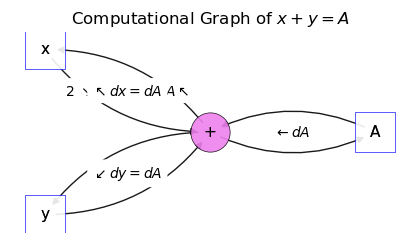

In [253]:
options1 = {
    "font_size": 11,
    "node_size": 800,
    "node_color": "white",
    "node_shape": "s",
    "edgecolors": "blue",
    "linewidths": 0.5,
    "width": 0,
    "alpha": 0.9,
}
options2 = {
    "font_size": 11,
    "node_size": 800,
    "node_color": "violet",
    "node_shape": "o",
    "edgecolors": "black",
    "linewidths": 0.5,
    "width": 0,
    "alpha": 0.9,
}
subset_sizes = (2, 1, 1)
node_labels = ['x', 'y', '+', 'A']
node_shapes = ['s', 's', 'o', 's']
edges = [(0, 2), (1, 2), (2, 3), (3, 2), (2, 1), (2, 0)]
edge_labels = [r'2 $\searrow \quad\quad dx=dA \nwarrow$', r'3 $\nearrow$', r'5 $\rightarrow$', r'$\leftarrow dA$', r'$\swarrow dy=dA$', r'$\nwarrow dx=dA$']
G = nx.DiGraph()
extents = nx.utils.pairwise(itertools.accumulate((0, ) + subset_sizes)) #[(0, 2), (2, 3), (3, 4)]
layers = [range(start, end) for start, end in extents]
for (i, layer) in enumerate(layers):
    G.add_nodes_from(layer, layer=i)
for n in G.nodes:
    G.nodes[n]['label'] = node_labels[n]

G_ = G.copy()
# curved_edges = [edge for edge in G.edges() if reversed(edge) in G.edges()]
# print(curved_edges)
edge_labels_list = [(start, end, {'label': edge_labels[i]}) for i, (start, end) in enumerate(edges)] 
G.add_edges_from(edge_labels_list)
edge_labels_dict = {edge: G.edges[edge]['label'] for edge in G.edges()}
print(G.edges.data(True))
print(G.nodes.data(True))
print(edge_labels_dict)
pos = nx.multipartite_layout(G, subset_key="layer")
labels = nx.get_node_attributes(G, 'label')
plt.figure(figsize=(4, 2))
H1 = G.subgraph([0, 1, 3])
H2 = G.subgraph([2])
nx.draw(H1, pos=pos, labels=labels, with_labels=True, **options1)
nx.draw(H2, pos=pos, labels=labels, with_labels=True, **options2)
nx.draw_networkx_edges(G, pos=pos, connectionstyle='arc3, rad=0.25', alpha=0.9, width=1 )

G_.add_edges_from(edge_labels_list[:3])
edge_labels_dict2 = {edge: G_.edges[edge]['label'] for edge in G_.edges()}
plt.title('Computational Graph of $x+y=A$')
edge_labels = nx.draw_networkx_edge_labels(G_, pos=pos, font_color='r', edge_labels=edge_labels_dict2, label_pos=0.5, rotate=False)
edge_labels = nx.draw_networkx_edge_labels(G, pos=pos, horizontalalignment='center', edge_labels=edge_labels_dict, label_pos=0.5, rotate=False)
plt.axis("equal")
plt.show()

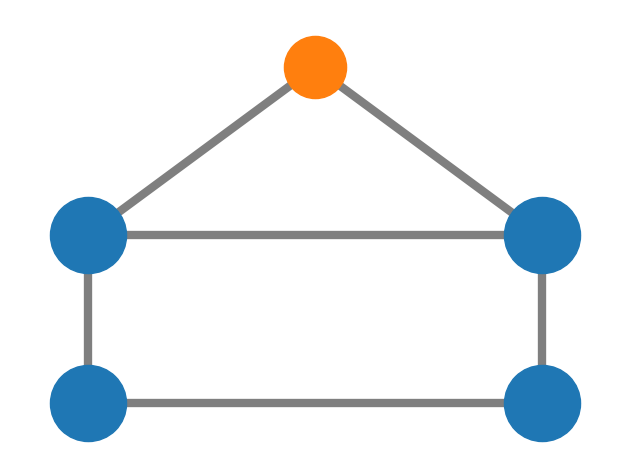

In [182]:
G = nx.house_graph()
# explicitly set positions
pos = {0: (0, 0), 1: (1, 0), 2: (0, 1), 3: (1, 1), 4: (0.5, 2.0)}

# Plot nodes with different properties for the "wall" and "roof" nodes
nx.draw_networkx_nodes(
    G, pos, node_size=3000, nodelist=[0, 1, 2, 3], node_color="tab:blue"
)
nx.draw_networkx_nodes(G, pos, node_size=2000, nodelist=[4], node_color="tab:orange")
nx.draw_networkx_edges(G, pos, alpha=0.5, width=6)
# Customize axes
ax = plt.gca()
ax.margins(0.11)
plt.tight_layout()
plt.axis("off")
plt.show()

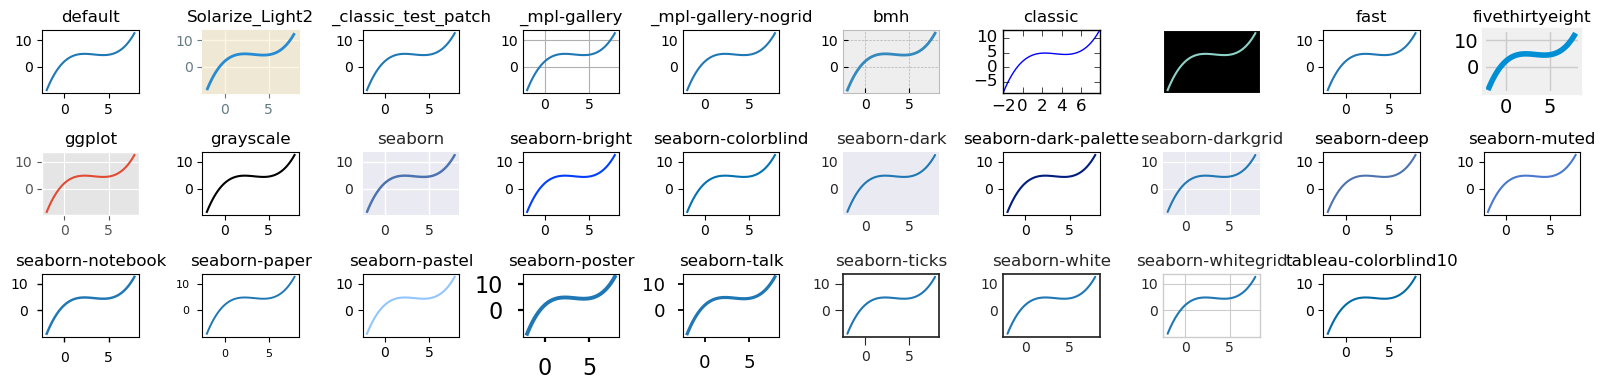

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

x = np.arange(-2, 8, .1)
y = .1 * x ** 3 - x ** 2 + 3 * x + 2
# plt.xkcd() # may use with context : with plt.xkcd(): ...
# plt.rcdefaults()
fig = plt.figure(dpi=100, figsize=(16, 4), tight_layout=True)
available = ['default'] + plt.style.available
for i, style in enumerate(available):
    with plt.style.context(style):
        ax = fig.add_subplot(3, 10, i + 1)
        ax.plot(x, y)
    ax.set_title(style)

In [ ]:
from turtle import forward


class AdditionGate:
    """
    Gate performing addition of TWO operands of numpy ndarray. 
    dfdu: backward coming value (df/du) of derivative  (df/du) * (du/dx) by chain rule.
    """
    def __init__(self) -> None:
        self.x = None
        self.y = None

    def forward(self, x, y):
        self.x = x
        self.y = y
        return self.x + self.y

    def backward(self, dfdu):
        dx = dfdu
        dy = dfdu
        return dx, dy
        

class MultiplicationGate:
    def __init__(self, x=1, y=1) -> None:
        self.x = None
        self.y = None

    def forward(self, x, y):
        self.x = x
        self.y = y
        return self.x * self.y

    def backward(self, dfdu):
        dx = dfdu * self.y
        dy = dfdu * self.x
        return dx, dy

class InverseGate:
    def __init__(self) -> None:
        self.x = None

    def forward(self, x):
        self.x = x
        return 1 / self.x 

    def backward(self, dfdu):
        dx = dfdu * (- 1/self.x**2)
        return dx

class MultipleGate:
    def __init__(self) -> None:
        self.x = None
        self.n = None

    def forward(self, x, n):
        self.x = x
        self.n = n
        return x**n

    def backward(self, dfdu):
        dx = dfdu * self.n * self.x**(self.n - 1)
        return dx

class SigmoidGate:
    def __init__(self) -> None:
        self.x = None
        self.out = None
    
    def forward(self, x):
        self.x = x
        self.out = 1/(1+np.exp(-x))
        return self.out

    def backward(self, dfdu):
        dx = dfdu * (1 - self.out) * self.out
        return dx

class SoftmaxGate:
    def __init__(self) -> None:
        self.y = None
        self.out = None

    def forward(self, y):
        self.y = y
        self.out = self.softmax(y)
        return self.out
    
    def backward(self, dfdu):
        pass
    
    def softmax(self, a):
        if a.ndim == 2:
            a = a.T
            C = np.max(a, axis=0)
            ex = np.exp(a - C)
            return (ex/np.sum(ex, axis=0)).T
        elif a.ndim == 1:
            C = np.max(a)
            ex = np.exp(a - C)
            return ex / np.sum(ex)
        else:
            print("Input must be a numpy ndarray of 1 or 2 dimesion.")
            raise TypeError
